In [1]:
from openket import *
from scipy.integrate import odeint
from sympy import var, I
import numpy as np
import matplotlib.pyplot as plt
import math
import importlib

plt.style.use('default')
cmap = plt.cm.Set2

2025-09-22 15:31:02,673 - openket - INFO - openket v0.1.0 initialized successfully.


In [2]:
hbar = 1.0
omega_c = 1.0  # frecuencia de la cavidad (unidad de referencia)
omega_b = 1.0 # frecuencia del bombeo, inyección de energía desde el láser externo (unidad de referencia)
rabi_b = 2.0 # tasa del bombeo, proporcional a la amplitud del campo eléctrico del láser
detuning = omega_c - omega_b # detuning entre frecuencia de la cavidad y frecuencia del láser

kappa = 0.1
alpha = 1
nmax = 5 # truncación del espacio de Hilbert (número de estados de Fock)
dt = 1000
t = np.linspace(0, 15, dt)

base = [Ket(i, "campo") for i in range(nmax)]
rho = Operator("R")
a = AnnihilationOperator("campo", nmax-1)
aa = CreationOperator("campo", nmax-1)

In [3]:
# Condición inicial: estado coherente |alpha⟩
state_alpha = 0
for i in range(nmax):
        state_alpha = state_alpha + ((alpha**2) / math.sqrt(math.factorial(i))) * Ket(i,"campo")
state_alpha = np.exp(-(np.abs(alpha)**2)/2) * state_alpha
#rho0 = state_alpha * dag(state_alpha)
rho0 = Ket(0,"campo") * dag(Ket(0,"campo"))

In [5]:
linestyles = ["solid", "dashed", "dotted"]
files = []
# generación del archivo de EDOs
deltas = [0.0, 0.5, 1.0]
for detuning in deltas:
    H_c = hbar * detuning * (aa * a + 1 / 2) # Hamiltoniano del oscilador armónico cuántico (cavidad)
    H_b = I*hbar * rabi_b * (aa - a) # Hamiltoniano del bombeo (láser)
    H = H_c + H_b # Hamiltoniano total
    # ecuación de movimiento de Lindblad
    rdot = I/hbar * comm(H,rho) + (kappa/2)*(2*a*rho*aa - aa*a*rho - rho*aa*a)

    filename = f"delta{str(detuning).replace('.','')}"
    files.append(filename)
    build_ode(rho=rho, rdot=rdot, basis=base, filetype="Scipy", filename=f"{filename}.py")

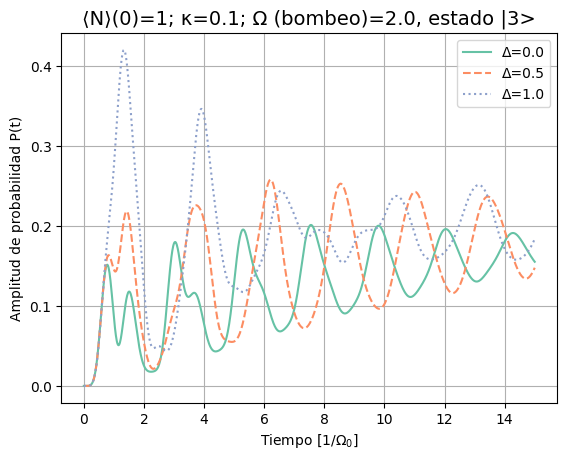

In [10]:
for i,file in enumerate(files):
    module = importlib.import_module(file)
    f = module.f
    dic = module.dic

    # convertir condiciones iniciales simbólicas -> numéricas
    init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
    # solución numérica
    rho_solution = odeint(f, init_conditions, t)

    # Probabilidad
    rho_complex = rho_solution[:, ::2] + 1j * rho_solution[:, 1::2] # convierte la matriz a entradas complejas
    rho_complex = rho_complex.reshape(dt, nmax, nmax) # pasa de matriz plana a matriz densidad nxn para cada t
    rho_nn = np.diagonal(np.abs(rho_complex), axis1=1, axis2=2) # extrae los elementos diagonales

    estado = 0
    plt.plot(t, rho_nn[:,estado], label=f'Δ={deltas[i]}', color=cmap(i), linestyle=linestyles[i])
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Amplitud de probabilidad P(t)')
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Ω (bombeo)={rabi_b}, estado |{estado}>', fontsize=14)
plt.grid(True)
plt.legend()
plt.savefig(f"P|{estado}>_deltas_k={kappa}_rabi={rabi_b}.png")

In [11]:
# Valores esperados
# definición simbólica de los observables
N = aa * a # operador de número
X = (1/np.sqrt(2)) * (a+aa) # cuadratura X adimensional
P = (1/np.sqrt(2)) * I*(aa-a) # cuadratura P adimensional

N_symb = sub_qexpr(qexpr=trace(rho * N, basis=base), dic=dic)
X_symb = sub_qexpr(qexpr=trace(rho * X, basis=base), dic=dic)
P_symb = sub_qexpr(qexpr=trace(rho * P, basis=base), dic=dic)

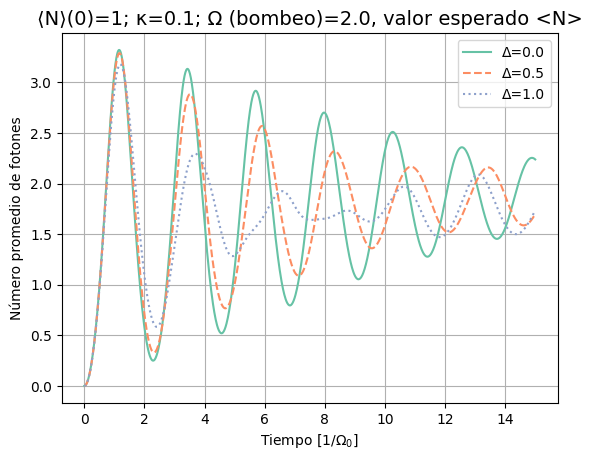

In [12]:
for i,file in enumerate(files):
    module = importlib.import_module(file)
    f = module.f
    dic = module.dic

    # convertir condiciones iniciales simbólicas -> numéricas
    init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
    # solución numérica
    rho_solution = odeint(f, init_conditions, t)
    # Valor esperado <N>
    N_expect = sym2num(sol=rho_solution, symbexpr=N_symb)

    plt.plot(t, np.real(N_expect), label=f'Δ={deltas[i]}', color=cmap(i), linestyle=linestyles[i])
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Ω (bombeo)={rabi_b}, valor esperado <N>', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Número promedio de fotones')
plt.legend()
plt.grid()
plt.savefig(f"<N>_deltas_k={kappa}_rabi={rabi_b}.png")

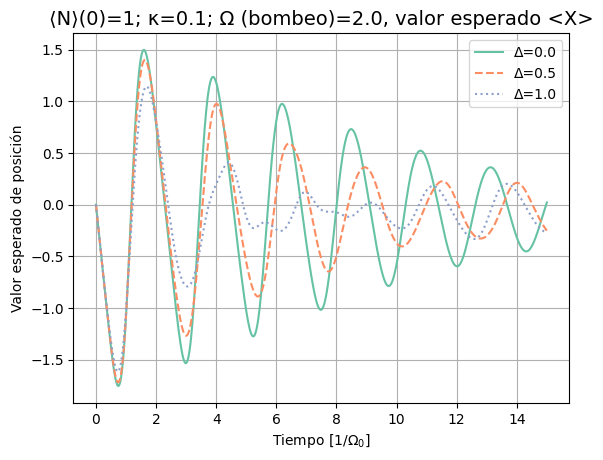

In [13]:
for i,file in enumerate(files):
    module = importlib.import_module(file)
    f = module.f
    dic = module.dic

    # convertir condiciones iniciales simbólicas -> numéricas
    init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
    # solución numérica
    rho_solution = odeint(f, init_conditions, t)
    # Valor esperado <X>
    X_expect = sym2num(sol=rho_solution, symbexpr=X_symb)

    plt.plot(t, np.real(X_expect), label=f'Δ={deltas[i]}', color=cmap(i), linestyle=linestyles[i])
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Ω (bombeo)={rabi_b}, valor esperado <X>', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Valor esperado de posición')
plt.legend()
plt.grid()
plt.savefig(f"<X>_deltas_k={kappa}_rabi={rabi_b}.png")

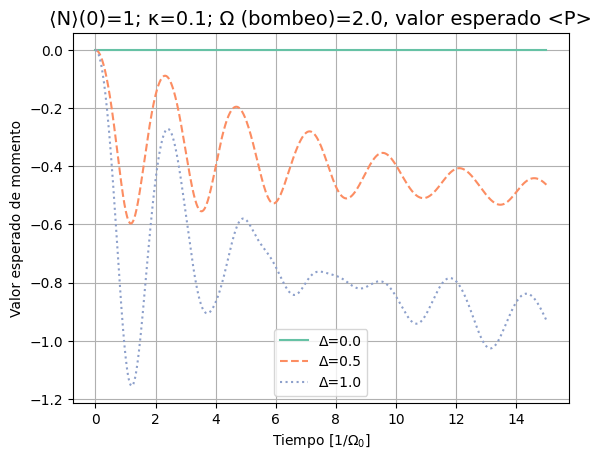

In [14]:
for i,file in enumerate(files):
    module = importlib.import_module(file)
    f = module.f
    dic = module.dic

    # convertir condiciones iniciales simbólicas -> numéricas
    init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
    # solución numérica
    rho_solution = odeint(f, init_conditions, t)
    # Valor esperado <P>
    P_expect = sym2num(sol=rho_solution, symbexpr=P_symb)

    plt.plot(t, np.real(P_expect), label=f'Δ={deltas[i]}', color=cmap(i), linestyle=linestyles[i])
plt.title(f'⟨N⟩(0)={alpha**2}; κ={kappa}; Ω (bombeo)={rabi_b}, valor esperado <P>', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Valor esperado de momento')
plt.legend()
plt.grid()
plt.savefig(f"<P>_deltas_k={kappa}_rabi={rabi_b}.png")